# Libraries and Updating Pytorch

In [1]:
!pip install -U torch

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)


In [66]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch
from torchvision import transforms
from torchvision import datasets, models, transforms
import shutil
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [67]:
torch.__version__

'1.8.1+cu101'

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pwd

'/content'

# Data Loader
* Commented as it is run once. 

In [7]:
# % mkdir dataset
# % cd ./dataset/
# ! git clone https://github.com/EscVM/OIDv4_ToolKit.git
# % cd  ./OIDv4_ToolKit
# ! pip install -r ./requirements.txt
# ! python main.py downloader --classes Coffee --type_csv train --limit 500


/content/dataset
Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 40.67 MiB/s, done.
Resolving deltas: 100% (146/146), done.
/content/dataset/OIDv4_ToolKit

		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|   

# Data Transformations

In [68]:
transform = transforms.Compose([
    transforms.Resize([500,500]),
     transforms.ToTensor()
])

In [69]:
train_data_path = '/content/dataset/OIDv4_ToolKit/OID/Dataset/train'
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transform)
  

# Defining Encoder and Decoders

In [70]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,16,3,padding=1,stride=2),  #batchsize x 16 x 250 x 250
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(16,32,3,padding=1,stride=2),  #batchsize x 32 x 125 x 125
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(32,64,3,padding=1,stride=2),   #batchsize x 64 x 63 x 63
        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(64,128,3,padding=1,stride=2),   #batchsize x 128 x 32 x 32
        nn.ReLU()
    )

    self.layer5 = nn.Sequential(                  #batchsize x 256 x 26 x 26
        nn.Conv2d(128,256,7)
    )

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    return x
    

In [71]:
encoder = Encoder().cuda()

In [72]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()

    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(256,128,7),                 # batchsize x 128 x 32 x 32
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        
        nn.ConvTranspose2d(128,64,3,padding=1,stride=2),   # batchsize x 64 x 63 x 63
        nn.ReLU()

    )

    self.layer3 = nn.Sequential(
        
        nn.ConvTranspose2d(64,32,3,padding=1,stride=2),   # batchsize x 32 x 125 x 125
        nn.ReLU()

    )

    self.layer4 = nn.Sequential(
        
        nn.ConvTranspose2d(32,16,3,padding=1,stride=2,output_padding=1), # batchsize x 16 x 250 x 250
        nn.ReLU()
    )

    self.layer5 = nn.Sequential(
        nn.ConvTranspose2d(16,3,3,padding=1,stride=2,output_padding=1),  # batchsize x 3 x 500 x 500
    )

  def forward(self,x):
    #print("decode1: ",x.size())
    x = self.layer1(x)
    #print("decode2: ",x.size())
    x = self.layer2(x)
    #print("decode3: ",x.size())
    x = self.layer3(x)
    #print("decode4: ",x.size())
    x = self.layer4(x)
    #print("decode5: ",x.size())
    x = self.layer5(x)
    #print("decode6: ",x.size())
    return x



In [73]:
decoder = Decoder().cuda()

# Running the model

In [74]:
batch_size = 100
learning_rate = 1e-3
epoch = 100
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

In [75]:
for i in range(epoch):
    print("Epoch: ",i)
    for image,label in train_loader:
        image = Variable(image).cuda()
        #label = Variable(label.float()).cuda()
        optimizer.zero_grad()
        output = encoder(image)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)


Epoch:  0
tensor(0.2732, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch: 

# Saving Model and parameters

In [77]:
PATH_encoder_model = "/content/encoder.pth"
torch.save(encoder, PATH_encoder)

PATH_decoder = "/content/decoder.pth"
torch.save(decoder, PATH_decoder)

PATH_decoder_dict = "/content/decoder_dict"
PATH_encoder_dict = "/content/encoder_dict"

torch.save(encoder.state_dict(),PATH_encoder_dict)
torch.save(decoder.state_dict(),PATH_decoder_dict)

# Testing on one image. (rest images are tested in other file)


In [78]:
encoder_test = torch.load(PATH_encoder)
encoder_test.eval()
decoder_test = torch.load(PATH_decoder)
decoder_test.eval()

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [21]:
# images123[0].shape

# Testing a random image

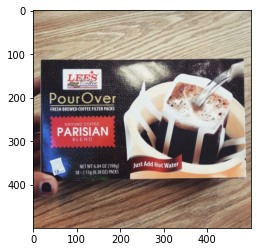

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


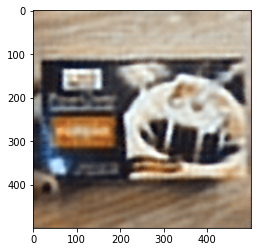

In [79]:
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images123, labels = dataiter.next()
out11 = encoder_test(images123.cuda())
out11 = decoder(out11)
plt.imshow(np.moveaxis(images123[1].detach().cpu().numpy(),0,-1))
plt.show()
plt.imshow(np.moveaxis(out11[1].detach().cpu().numpy(),0,-1))
plt.show()